In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import pickle
import data_utils
import matplotlib.pyplot as plt
import re
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

/Users/shivanikohli/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from collections import Counter

def read_sentences(file_path):
	sentences = []

	with open(file_path, 'r') as reader:
		for s in reader:
			sentences.append(s.strip())

	return sentences

def iteritems(dic):
    return iter([(key, dic[key]) for key in dic])

def create_dataset(en_sentences, sn_sentences):

	en_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in en_sentences for word in sentence.split())
	sn_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in sn_sentences for word in sentence.split())

	en_vocab = list(map(lambda x: x[0], sorted(en_vocab_dict.items(), key = lambda x: -x[1])))
	sn_vocab = list(map(lambda x: x[0], sorted(sn_vocab_dict.items(), key = lambda x: -x[1])))

	en_vocab = en_vocab[:20000]
	sn_vocab = sn_vocab[:30000]

	start_idx = 2
	en_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(en_vocab)])
	en_word2idx['<ukn>'] = 0
	en_word2idx['<pad>'] = 1

	en_idx2word = dict([(idx, word) for word, idx in iteritems(en_word2idx)])


	start_idx = 4
	sn_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(sn_vocab)])
	sn_word2idx['<ukn>'] = 0
	sn_word2idx['<go>']  = 1
	sn_word2idx['<eos>'] = 2
	sn_word2idx['<pad>'] = 3

	sn_idx2word = dict([(idx, word) for word, idx in iteritems(sn_word2idx)])

	x = [[en_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in en_sentences]
	y = [[sn_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in sn_sentences]

	X = []
	Y = []
	for i in range(len(x)):
		n1 = len(x[i])
		n2 = len(y[i])
		n = n1 if n1 < n2 else n2 
		if abs(n1 - n2) <= 0.3 * n:
			if n1 <= 15 and n2 <= 15:
				X.append(x[i])
				Y.append(y[i])

	return X, Y, en_word2idx, en_idx2word, en_vocab, sn_word2idx, sn_idx2word, sn_vocab

def save_dataset(file_path, obj):
	with open(file_path, 'wb') as f:
		pickle.dump(obj, f, -1)

def main():
    en_sentences = read_sentences('./Data/bible.en')
    sn_sentences = read_sentences('./Data/bible.san')

    save_dataset('./Data/bible2.pkl', create_dataset(sn_sentences, en_sentences))

In [5]:
main()

In [6]:
def convert_sanskrit(uni):
    a = bytearray(uni, encoding = "utf-8").decode('unicode-escape')
    return a

In [15]:
# read dataset
def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f,encoding="utf_8")

X, Y, sn_word2idx, sn_idx2word, sn_vocab, en_word2idx, en_idx2word, en_vocab = read_dataset('./Data/data.pkl')

In [17]:
#inspecting data
print('Sentence in Sanskrit - encoded:', X[0])
print('Sentence in English - encoded:', Y[0])
print('Decoded:\n------------------------')

for i in range(len(X[3])):
    print(convert_sanskrit(sn_idx2word[X[3][i]]), end = " ")
    
print('\n')

for i in range(len(Y[3])):
    print(en_idx2word[Y[3][i]], end = " ")

Sentence in Sanskrit - encoded: [688, 1181, 506, 6, 1181, 11328, 0]
Sentence in English - encoded: [5, 583, 6, 5, 462, 6, 39, 139, 0, 5, 62, 6, 333, 0, 5, 62, 6, 328, 0]
Decoded:
------------------------
तस्य पुत्रो ऽम्मीनादब् तस्य पुत्रो नहशोन् तस्य पुत्रः सल्मोन्। 

and aram begat aminadab <ukn> and aminadab begat naasson <ukn> and naasson begat salmon <ukn> 

In [18]:
print(sum([len(sentence) for sentence in X]) / len(X))
print(sum([len(sentence) for sentence in Y]) / len(Y))

11.58403468502933
21.631981637337415


In [19]:
# data processing

# data padding
def data_padding(x, y, length = 10):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [sn_word2idx['<pad>']]
        y[i] = [en_word2idx['<go>']] + y[i] + [en_word2idx['<eos>']] + (length-len(y[i])) * [en_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [21]:
input_seq_len = 10
output_seq_len = 12
sn_vocab_size = len(sn_vocab) + 2 # + <pad>, <ukn>
en_vocab_size = len(en_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [en_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [en_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = sn_vocab_size,
                                            num_decoder_symbols = en_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [22]:
# define our loss function

def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = en_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [29]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = en_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == en_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [24]:
saver = tf.train.Saver()

In [30]:
# ops and hyperparameters
learning_rate = 0.002
batch_size = 512
steps = 20000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)


In [31]:
# we will use this list to plot losses through steps
losses = []

In [32]:
# let's train the model

# save a checkpoint so we can restore the model later 

# checkpointsPath = './checkpoints501previous/'
restore = False
starting_step = 0

print('------------------TRAINING------------------')
with tf.Session() as sess:
    if (restore):
        print('Restoring')
        with open(checkpointsPath + 'checkpoint') as f:
            starting_step = int(re.match('model_checkpoint_path: "-([0-9]+)"', list(f)[0]).groups()[0]) + 1
        saver.restore(sess, tf.train.latest_checkpoint(checkpointsPath))
        print('Running from step {}'.format(starting_step))
    else:
        print('Running from scratch: generating random model parameters.')
        sess.run(init)
    
    t = time.time()
    for step in range(starting_step, starting_step + steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, checkpointsPath, global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
Running from scratch: generating random model parameters.
step: 0, loss: 8.284358978271484
step: 4, loss: 8.286918640136719


KeyboardInterrupt: 

In [33]:
tf.restore()

AttributeError: module 'tensorflow' has no attribute 'restore'

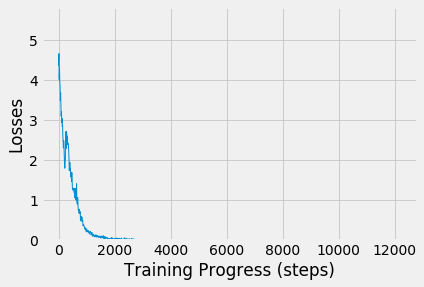

In [51]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps (from step {})'.format(starting_step))
    plt.ylabel('Losses')
    plt.ylim((0, 1))

plt.show()

In [53]:
f = pd.DataFrame(columns=['Translation', 'Expected', 'Bleu_Score'])

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [en_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [en_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = sn_vocab_size,
                                                num_decoder_symbols = en_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    sn_sentences_encoded = X_train
    en_sentences_encoded = Y_train
    sn_sentences_extra = []#'तर्हि मम वाक्यानि कथं प्रत्येष्यथ', 'मानव इव कोपि कदापि नोपादिशत्']
    en_sentences_extra = []#'how shall ye believe my words', 'Never man spake like this man']
    sn_sentences_encoded += [[sn_word2idx[word] if word in sn_word2idx else sn_word2idx['<ukn>'] for word in sentence.encode('unicode-escape').decode('utf-8').split()] for sentence in sn_sentences_extra]
    en_sentences_encoded += [[en_word2idx[word] if word in en_word2idx else en_word2idx['<ukn>'] for word in sentence.split()] for sentence in en_sentences_extra]
    # padding to fit encoder input
    for i in range(len(sn_sentences_encoded)):
        sn_sentences_encoded[i] += (15 - len(sn_sentences_encoded[i])) * [sn_word2idx['<pad>']]
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint(checkpointsPath)
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([sn_sentences_encoded[j][i] for j in range(len(sn_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([en_word2idx['<go>']] * len(sn_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(sn_sentences_encoded)):
            print('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
            expected = [en_idx2word[word] for word in en_sentences_encoded[i]]
        
            print(" ". join([convert_sanskrit(sn_idx2word[word]) for word in sn_sentences_encoded[i] if word is not sn_word2idx['<pad>']]))
            #print(" ". join([(en_idx2word[word]) for word in en_sentences_encoded[i]]))
            
            translation_bleu = []
            print('Translated: ', end = " ")
            for j in range(len(words)):
                if words[j] not in ['<eos>', '<pad>', '<go>']:
                    print((words[j]), end = " ")
                    translation_bleu.append(words[j])
            print()
            expected_bleu = []
            print('  Expected: ', end = " ")
            for j in range(len(expected)):
                if expected[j] not in ['<eos>', '<pad>', '<go>']:
                    print(expected[j], end = " ")
                    expected_bleu.append(expected[j])
            print()
            
            bleu_score = sentence_bleu([expected_bleu], translation_bleu)
            
            df = df.append(other = {'Translation':translation_bleu, 'Expected':expected_bleu, 'Bleu_Score':bleu_score},ignore_index=True)
            print('Bleu Score: ', end = " ")
            print(bleu_score)

            print('\n--------------------------------')

393
INFO:tensorflow:Restoring parameters from ./checkpoints501/-12299
1.
--------------------------------
तस्मात् ते गत्वा तस्य प्रयोजनीयद्रव्याणि संग्रहीतुं शोमिरोणीयानां ग्रामं प्रविविशुः। <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
\u0924\u0938\u094d\u092e\u093e\u0924\u094d \u0924\u0947 \u0917\u0924\u094d\u0935\u093e \u0924\u0938\u094d\u092f \u092a\u094d\u0930\u092f\u094b\u091c\u0928\u0940\u092f\u0926\u094d\u0930\u0935\u094d\u092f\u093e\u0923\u093f \u0938\u0902\u0917\u094d\u0930\u0939\u0940\u0924\u0941\u0902 \u0936\u094b\u092e\u093f\u0930\u094b\u0923\u0940\u092f\u093e\u0928\u093e\u0902 \u0917\u094d\u0930\u093e\u092e\u0902 \u092a\u094d\u0930\u0935\u093f\u0935\u093f\u0936\u0941\u0903\u0964 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Translation:  and they reasoned for every multitude had prayed <ukn> and they could not his 